In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Define constants
IMG_SIZE = 256
BATCH_SIZE = 32
CHANNEL = 3
EPOCHS = 50

In [4]:
# Load the dataset
ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Code/potato-disease/Training/PlantVillage",
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
# Get class names
classes = ds.class_names
print(classes)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


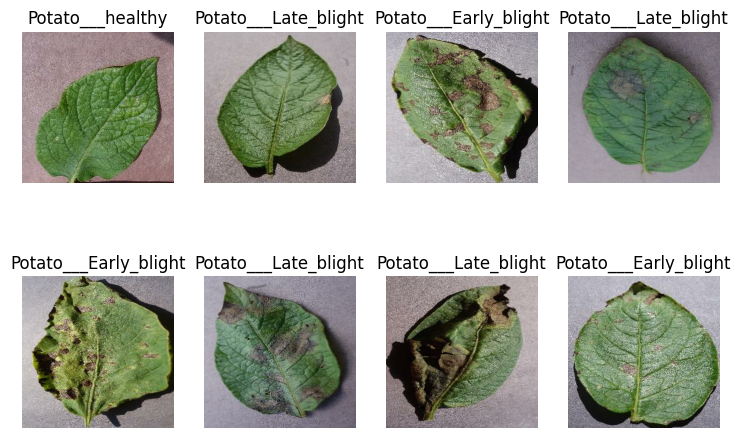

In [6]:
# Display sample images from the dataset
plt.figure(figsize=(9, 9))

for img, lbl in ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(classes[lbl[i]])
        plt.axis("off")

In [7]:
# Data Partitioning
def partition_ds(ds, shuffle=True):
    ds_size = len(ds)

    train_ds_size = int(0.8 * ds_size)
    ds_train = ds.take(train_ds_size)

    val_ds_size = int(0.1 * ds_size)
    ds_validation = ds.skip(train_ds_size).take(val_ds_size)

    ds_test = ds.skip(train_ds_size).skip(val_ds_size)

    return ds_train, ds_validation, ds_test
    
ds_train, ds_validation, ds_test = partition_ds(ds)

In [8]:
# Data Preprocessing and Augmentation

autotune = tf.data.AUTOTUNE

ds_train = ds_train.cache().shuffle(1000).prefetch(buffer_size=autotune)
ds_validation = ds_validation.cache().shuffle(1000).prefetch(buffer_size=autotune)
ds_test = ds_test.cache().shuffle(1000).prefetch(buffer_size=autotune)

new_scale__new_size = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
])

data_augm = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.3)
])

In [9]:
# Model Definition

model = models.Sequential([
    new_scale__new_size,
    data_augm,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, CHANNEL)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.build(input_shape=(BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNEL))

In [10]:
# Model Compilation

model.compile(
    optimizer='SGD',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
# Model Training

train_model = model.fit(
    ds_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=ds_validation
)

Epoch 1/50
54/54 [==============================] - 4s 65ms/step - loss: 0.0754 - accuracy: 0.9745 - val_loss: 0.0635 - val_accuracy: 0.9844
Epoch 2/50
54/54 [==============================] - 3s 62ms/step - loss: 0.0636 - accuracy: 0.9792 - val_loss: 0.0902 - val_accuracy: 0.9583
Epoch 3/50
54/54 [==============================] - 3s 63ms/step - loss: 0.0662 - accuracy: 0.9728 - val_loss: 0.0457 - val_accuracy: 0.9792
Epoch 4/50
54/54 [==============================] - 3s 64ms/step - loss: 0.0736 - accuracy: 0.9711 - val_loss: 0.0534 - val_accuracy: 0.9896
Epoch 5/50
54/54 [==============================] - 3s 63ms/step - loss: 0.0874 - accuracy: 0.9699 - val_loss: 0.0788 - val_accuracy: 0.9688
Epoch 6/50
54/54 [==============================] - 3s 62ms/step - loss: 0.0825 - accuracy: 0.9670 - val_loss: 0.0769 - val_accuracy: 0.9635
Epoch 7/50
54/54 [==============================] - 3s 62ms/step - loss: 0.0643 - accuracy: 0.9774 - val_loss: 0.1092 - val_accuracy: 0.9583
Epoch 8/50
54

In [20]:
# Model Evaluation

scores = model.evaluate(ds_test)

8/8 [==============================] - 0s 26ms/step - loss: 0.0877 - accuracy: 0.9784


Text(0.5, 1.0, 'Training and Validation Loss')

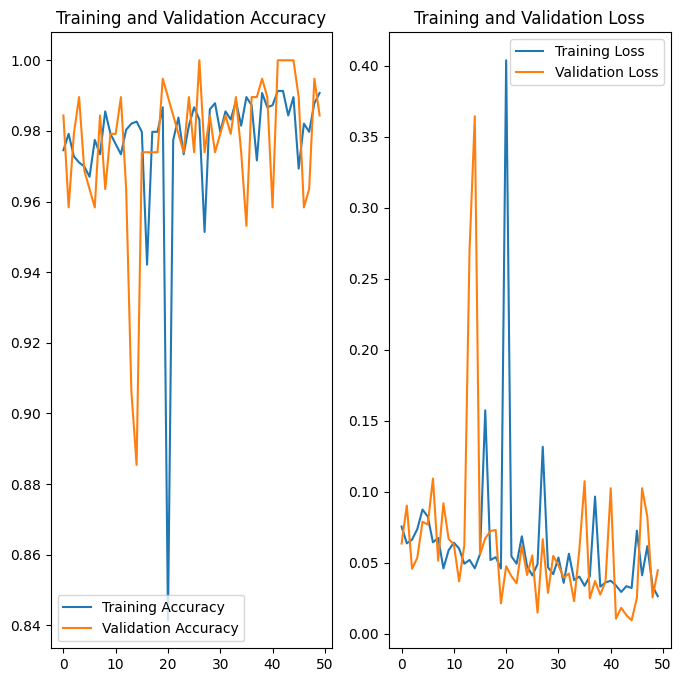

In [21]:
# Plot Accuracy and Loss

accuracy = train_model.history['accuracy']
val_accuracy = train_model.history['val_accuracy']
loss = train_model.history['loss']
val_loss = train_model.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Validation Loss')

In [23]:
# Function to Predict Image Class

def predict_model(model, img):
    array_image = tf.keras.preprocessing.image.img_to_array(img)
    array_image = tf.expand_dims(array_image, 0)

    image_predict = model.predict(array_image)

    class_prediction = classes[np.argmax(image_predict[0])]
    conf = round(100 * (np.max(image_predict[0])), 2)

    return class_prediction, conf


1/1 [==============================] - 0s 19ms/step


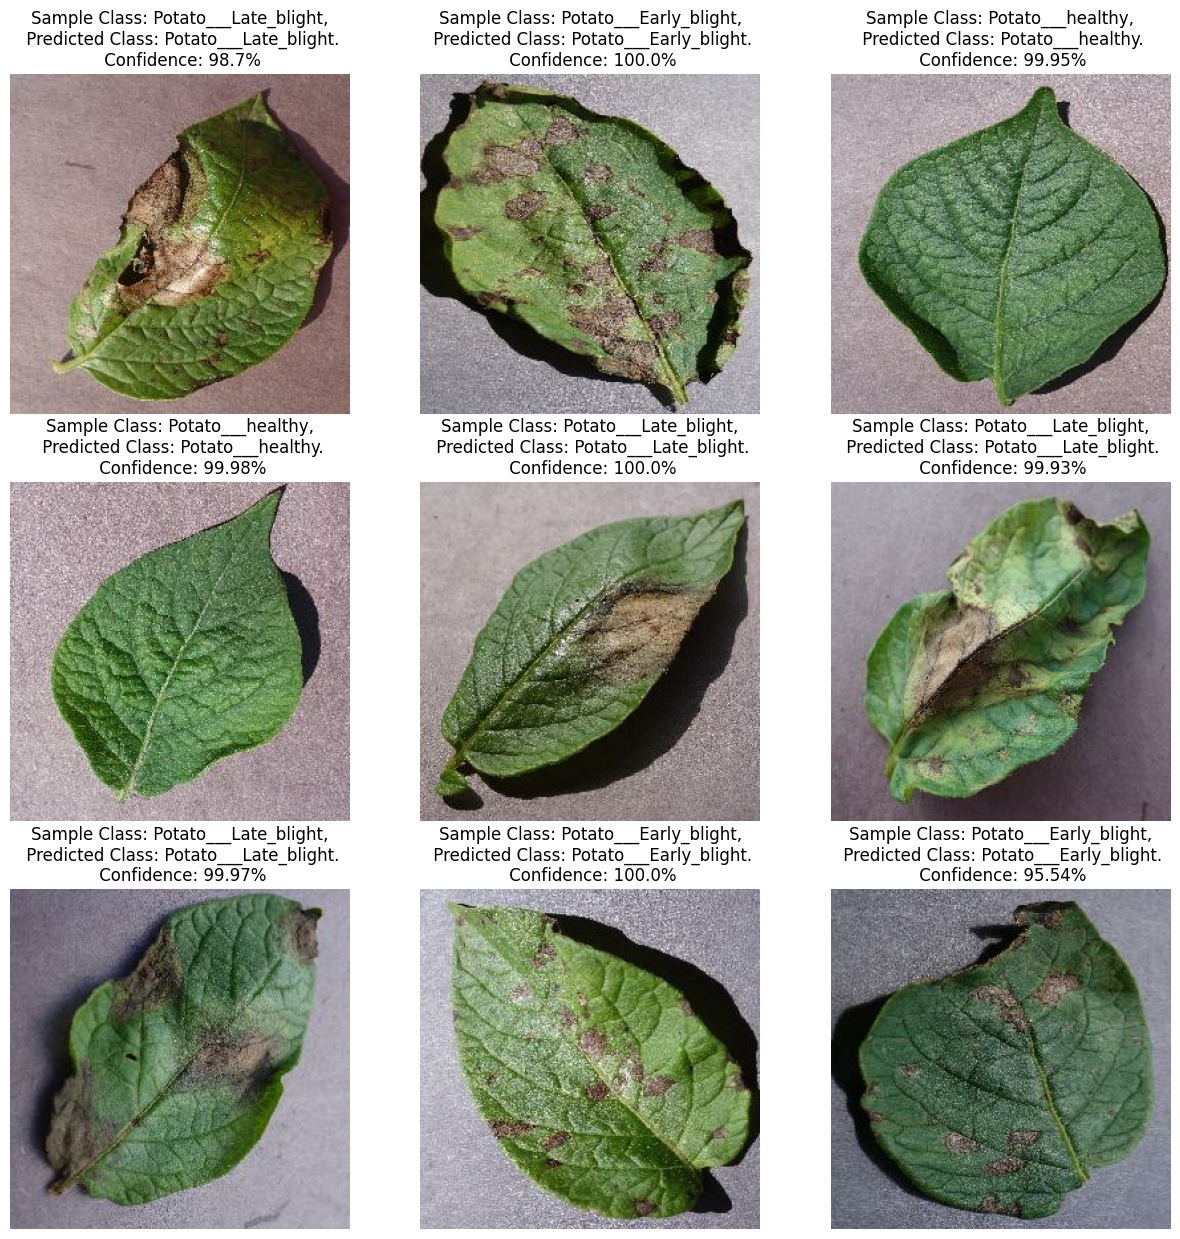

In [26]:
#Image prediction

plt.figure(figsize=(15,15))

for images, labels in ds_test.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_prediction, conf= predict_model(model, images[i].numpy())
    real_class = classes[labels[i]]
    plt.title(f"Sample Class: {real_class},\n Predicted Class: {class_prediction}.\n Confidence: {conf}%")
    plt.axis("off")